In [1]:
%load_ext autoreload
%autoreload 2
%run ./initializer

Added the path (/Users/madalenabarcelo/Desktop/BA/DMT/DataMiningTechniquesA1) to sys.path


In [2]:
import torch
import torch.nn as nn
import optuna
#from sklearn.model_selection import train_test_split
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from data_loading import DataPreprocessor
from random_forest_classifier_2a import plot_predicted_vs_actual
from random_forest_classifier_2a import split_train_val_per_id


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.5 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/usr/local/Cellar/python@3.10/3.10.16/Frameworks/Python.framework/Versions/3.10/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/local/Cellar/python@3.10/3.10.16/Frameworks/Python.framework/Versions/3.10/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/Users/madalenabarcelo/Desktop/BA/DMT/DataMiningTechniquesA1/notebooks/.venv/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.lau

In [3]:
data_loader = DataPreprocessor()
train_df, pred_df = data_loader.load_and_preprocess_data("1d", 0.5, 1, do_bucketing=False, for_RNN_model=False)

Removed 53 outliers from 1268 observations. Percentage: 4.18%


In [4]:
test_predictions = []
test_actuals = []
final_predictions = []
user_ids = []

# For each user
for id in train_df["id"].unique():
    train_group = train_df[train_df["id"] == id]

    # Keep date column for evaluation
    dates = train_group['date']

    # Then drop id, mood, and date for features
    features = train_group.drop(columns=['id', 'mood', 'date'])
    labels = train_group['mood']
    
    train_user_df, test_user_df = split_train_val_per_id(train_group, val_frac=0.2)

    X_train = train_user_df.drop(columns=["id", "mood", "date"])
    y_train = train_user_df["mood"]
    X_test = test_user_df.drop(columns=["id", "mood", "date"])
    y_test = test_user_df["mood"]


    model = RandomForestRegressor()
    model.fit(X_train, y_train)

    # Predict on the validation set
    y_test_pred = model.predict(X_test)
    test_predictions.extend(y_test_pred)
    test_actuals.extend(y_test)

    # Predict on the prediction set
    pred_group = pred_df[pred_df["id"] == id]
    X_pred = pred_group.drop(columns=["id", "date", "mood"])
    y_pred = model.predict(X_pred)

    final_predictions.append(y_pred[0])
    user_ids.append(id)


Validation Statistics
MAE: 0.5227959999999998
MSE: 0.5333136317777776
R²: 0.0941413150232403


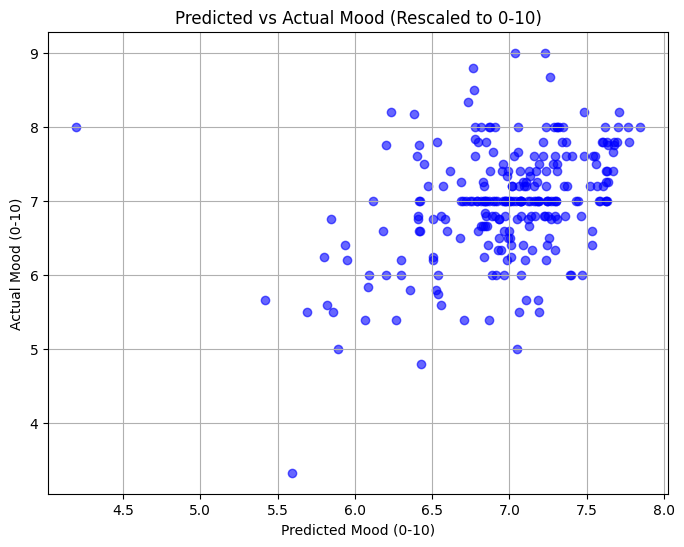

In [5]:
# Evaluate across all users
print("Validation Statistics")
print("MAE:", mean_absolute_error(test_actuals, test_predictions))
print("MSE:", mean_squared_error(test_actuals, test_predictions))
print("R²:", r2_score(test_actuals, test_predictions))
plot_predicted_vs_actual(np.array(test_actuals), np.array(test_predictions))

In [6]:
# Optional: view predictions
results_df = pd.DataFrame({
    "user_id": user_ids,
    "predicted_next_day_mood": final_predictions,
})
print(results_df)

    user_id  predicted_next_day_mood
0   AS14.01                 7.305333
1   AS14.02                 7.265833
2   AS14.03                 7.835500
3   AS14.05                 7.083500
4   AS14.06                 6.990500
5   AS14.07                 3.997333
6   AS14.08                 6.695000
7   AS14.09                 6.410833
8   AS14.12                 6.591000
9   AS14.13                 7.116500
10  AS14.14                 6.872833
11  AS14.15                 7.076000
12  AS14.16                 6.755333
13  AS14.17                 7.044000
14  AS14.19                 6.486000
15  AS14.20                 6.942500
16  AS14.23                 7.212000
17  AS14.24                 6.910667
18  AS14.25                 7.065000
19  AS14.26                 7.332500
20  AS14.27                 7.338333
21  AS14.28                 7.079000
22  AS14.29                 7.190500
23  AS14.30                 7.545833
24  AS14.31                 7.053667
25  AS14.32                 7.409500
2